In [3]:
import pandas as pd 
import numpy as np 

#models 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

#
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, minmax_scale, MinMaxScaler

#metrics 
from sklearn.metrics import accuracy_score ,balanced_accuracy_score, make_scorer, confusion_matrix, f1_score, classification_report, roc_auc_score

import optuna


import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

import pickle

# Pre-processing 

In [8]:
df = pd.read_csv("../backup/data/df_annotated.csv")

In [5]:
df.shape

(92961, 9)

In [9]:
df

,timestamp,text,emojis,retweets,likes,comments,lexical_field,text_emojis,label
0,2020-01-01,le tout vendu à des prix \n«défiant toute conc...,NaN,NaN,NaN,NaN,cheap,NaN,NaN
1,2020-01-01,Pour ceux qui veulent allier l'utile à l'agréa...,🛑 🛑,NaN,NaN,NaN,cheap,Pour ceux qui veulent allier l'utile à l'agréa...,NaN
2,2020-01-02,"Nouvelle perspective: BARAKA BUSINESS SARL, ne...",NaN,3.0,NaN,NaN,cheap,NaN,not_about_prices
3,2020-01-02,J'ai du mal à savoir si #Cirelli a reçu la Leg...,NaN,3.0,1.0,NaN,cheap,NaN,NaN
4,2020-01-06,Un iPhone pas cher ? C’est maintenant possible...,⭐ 😉,284.0,69.0,36.0,cheap,Un iPhone pas cher ? C’est maintenant possible...,NaN
...,...,...,...,...,...,...,...,...,...
92956,2022-12-30,Mercredi 16h : on appelle pour visiter.\nJeudi...,🤯 🤯 🤯,31.0,NaN,4.0,prices,Mercredi 16h : on appelle pour visiter.\nJeudi...,NaN
92957,2022-12-30,"Avec la #Justinflation, les Canadiens ont vu f...",NaN,298.0,47.0,68.0,prices,NaN,NaN
92958,2022-12-30,La mairie de Biarritz a cessé de payer l’élec...,💡,58.0,11.0,3.0,prices,La mairie de Biarritz a cessé de payer l’élec...,NaN
92959,2022-12-30,L'architecte japonais Arata Isozaki est mort à...,NaN,20.0,8.0,4.0,prices,NaN,NaN


In [10]:
#keeping labelled data
df2=df[(df["label"].notna())]
df2.head(10)

,timestamp,text,emojis,retweets,likes,comments,lexical_field,text_emojis,label
2,2020-01-02,"Nouvelle perspective: BARAKA BUSINESS SARL, ne...",NaN,3.0,NaN,NaN,cheap,NaN,not_about_prices
23,2020-01-23,Pour vos permis toute catégorie a bon prix 80....,NaN,5.0,2.0,NaN,cheap,NaN,not_about_prices
94,2020-04-10,Ayez des téléphones de qualité à des prix défi...,NaN,4.0,1.0,NaN,cheap,NaN,not_about_prices
237,2020-07-21,Prix défiant toute concurrence. \nMP pour plus...,NaN,NaN,NaN,NaN,cheap,NaN,desinflation
285,2020-08-18,MAGIC TOUCH | Bizcongo\nNous confectionnons et...,NaN,NaN,NaN,NaN,cheap,NaN,not_about_prices
376,2020-10-13,#PrimeDay #VenteFlash Un ampli 15 w pour guita...,NaN,NaN,NaN,NaN,cheap,NaN,not_about_prices
415,2020-11-13,Vous avez des bon plans pour avoir des tenues ...,NaN,1.0,NaN,NaN,cheap,NaN,desinflation
553,2021-02-15,Notre sécurité et la sécurité de nos biens pas...,NaN,1.0,NaN,NaN,cheap,NaN,desinflation
564,2021-02-24,Admirez les nouveautés chez nous avec les stic...,NaN,2.0,2.0,NaN,cheap,NaN,not_about_prices
698,2021-06-06,[ALERTE] De nombreux consommateurs se retrouve...,NaN,12.0,9.0,NaN,cheap,NaN,not_about_prices


In [11]:
#creating column price and dummies for direction in price change
df2['Price']=(df2['label']!='not_about_prices')*1 #one if labelled as being about price
df2=pd.concat([df2,pd.get_dummies(df2['label'])], axis =1)
df2.drop(['label','not_about_prices'], axis =1, inplace =True)

In [12]:
df2

,timestamp,text,emojis,retweets,likes,comments,lexical_field,text_emojis,Price,deflation,desinflation,inflation,other,stability
2,2020-01-02,"Nouvelle perspective: BARAKA BUSINESS SARL, ne...",NaN,3.0,NaN,NaN,cheap,NaN,0,0,0,0,0,0
23,2020-01-23,Pour vos permis toute catégorie a bon prix 80....,NaN,5.0,2.0,NaN,cheap,NaN,0,0,0,0,0,0
94,2020-04-10,Ayez des téléphones de qualité à des prix défi...,NaN,4.0,1.0,NaN,cheap,NaN,0,0,0,0,0,0
237,2020-07-21,Prix défiant toute concurrence. \nMP pour plus...,NaN,NaN,NaN,NaN,cheap,NaN,1,0,1,0,0,0
285,2020-08-18,MAGIC TOUCH | Bizcongo\nNous confectionnons et...,NaN,NaN,NaN,NaN,cheap,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92688,2022-12-23,Amérique latine. Des économies qui ont effacé ...,NaN,6.0,2.0,1.0,prices,NaN,0,0,0,0,0,0
92769,2022-12-25,Si votre épargne sur une année (lunaire) est ...,🚨,81.0,43.0,3.0,prices,Si votre épargne sur une année (lunaire) est ...,0,0,0,0,0,0
92830,2022-12-27,Pire idée possible.\nÇa va coûter des milliard...,NaN,128.0,40.0,27.0,prices,NaN,0,0,0,0,0,0
92862,2022-12-28,Le deuxième prix Nobel de médecine à se dresse...,NaN,554.0,190.0,35.0,prices,NaN,0,0,0,0,0,0


In [13]:
df2['Price'].value_counts()

0    684
1    334
Name: Price, dtype: int64

In [302]:
### Filtering embeddings
index = df2.index

In [303]:
index

Int64Index([    2,    23,    94,   237,   285,   376,   415,   553,   564,
              698,
            ...
            92309, 92410, 92532, 92639, 92647, 92688, 92769, 92830, 92862,
            92875],
           dtype='int64', length=1018)

In [304]:
embeddings= np.load('../backup/data/embeddings.npy')
len(embeddings)

92961

In [305]:
len(embeddings[index])

1018

### pre-processing for modeling

In [306]:
Y = np.array(df2['Price'])
X=embeddings[index]

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.33, shuffle=True)

In [308]:
print(1-np.count_nonzero(y_test==1)/len(y_test)) #share of zeros in test set
print(1- np.count_nonzero(y_train==1)/len(y_train)) #share of zeros in train set

0.6755952380952381
0.6700879765395895


## `LinearSVC`

In [75]:
# Linear SVC
svc = LinearSVC(max_iter=5000)
parameters2 = {'C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf2 = GridSearchCV(svc, parameters2, cv=3)
clf2.fit(x_train, y_train)


print('Returned hyperparameter: {}'.format(clf2.best_params_))
print('Best classification accuracy in train is: {}'.format(clf2.best_score_))
print('Classification accuracy on test is: {}'.format(clf2.score(x_test, y_test)))

Returned hyperparameter: {'C': 1.0}
Best classification accuracy in train is: 0.8254952726898009
Classification accuracy on test is: 0.8244047619047619


### trying with `optuna`

In [76]:
def objective(trial):
    """Define the objective function"""

    params = {
        'C':trial.suggest_float("C", 1e-10, 1e10, log=True)}


    # Fit the model
    optuna_model = LinearSVC(**params)
    optuna_model.fit(x_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(x_test)

    # Evaluate predictions
    accuracy = f1_score(y_test, y_pred)
    return accuracy

In [77]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-01-31 08:59:12,042] A new study created in memory with name: no-name-31b44450-05d1-4d44-914e-06d23c58b653
[I 2023-01-31 08:59:12,069] Trial 0 finished with value: 0.0 and parameters: {'C': 3.858738566269327e-08}. Best is trial 0 with value: 0.0.
[I 2023-01-31 08:59:12,422] Trial 1 finished with value: 0.5679012345679012 and parameters: {'C': 2595043.6514355573}. Best is trial 1 with value: 0.5679012345679012.
[I 2023-01-31 08:59:12,430] Trial 2 finished with value: 0.0 and parameters: {'C': 7.335240996669778e-10}. Best is trial 1 with value: 0.5679012345679012.
[I 2023-01-31 08:59:12,439] Trial 3 finished with value: 0.0 and parameters: {'C': 5.163691867961332e-10}. Best is trial 1 with value: 0.5679012345679012.
[I 2023-01-31 08:59:12,799] Trial 4 finished with value: 0.5819672131147541 and parameters: {'C': 2156.3340066296773}. Best is trial 4 with value: 0.5819672131147541.
[I 2023-01-31 08:59:12,808] Trial 5 finished with value: 0.0 and parameters: {'C': 7.79067787543756e-0

In [78]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.743119266055046
  Params: 
    C: 0.16938740272876107


In [79]:
best_params = study.best_params

svc_clf=LinearSVC(**best_params)
svc_clf.fit(x_train, y_train)
y_pred = svc_clf.predict(x_test)

Text(0.5, 1.0, 'Matrice de confusion')

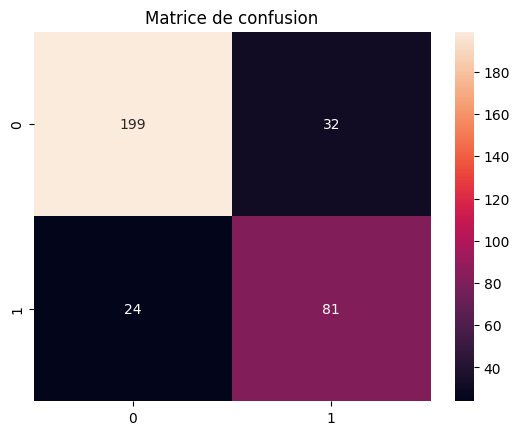

In [80]:
sns.heatmap(confusion_matrix(y_pred,y_test),fmt='.4g', annot=True).set_title('Matrice de confusion')

### `XGBClassifier`

In [81]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(x_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(x_test)

    # Evaluate predictions
    accuracy = f1_score(y_test, y_pred)
    return accuracy

In [82]:
study = optuna.create_study(direction='maximize')

[I 2023-01-31 08:59:20,859] A new study created in memory with name: no-name-c92faa86-0af2-4c92-acb9-0a8f17005e5f


In [83]:
study.optimize(objective, n_trials=100)

[I 2023-01-31 08:59:21,322] Trial 0 finished with value: 0.5135135135135136 and parameters: {'max_depth': 1, 'learning_rate': 0.7141595828475565, 'n_estimators': 415, 'min_child_weight': 3, 'gamma': 0.0011314156118654877, 'subsample': 0.03485767401146967, 'colsample_bytree': 0.1298682370089243, 'reg_alpha': 0.49387282807207256, 'reg_lambda': 0.0018614038370912695}. Best is trial 0 with value: 0.5135135135135136.
[I 2023-01-31 08:59:21,437] Trial 1 finished with value: 0.7177033492822967 and parameters: {'max_depth': 2, 'learning_rate': 0.16563853523403232, 'n_estimators': 132, 'min_child_weight': 7, 'gamma': 1.1150923813282806e-05, 'subsample': 0.203467987956964, 'colsample_bytree': 0.01765281485258612, 'reg_alpha': 3.22189622652181e-07, 'reg_lambda': 3.4186843156266303e-05}. Best is trial 1 with value: 0.7177033492822967.
[I 2023-01-31 08:59:21,513] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 3, 'learning_rate': 0.016573677976315572, 'n_estimators': 77, 'min_child_w

In [84]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7627906976744186
  Params: 
    max_depth: 5
    learning_rate: 0.011202205787774437
    n_estimators: 459
    min_child_weight: 4
    gamma: 0.003197155005876287
    subsample: 0.3810575317116091
    colsample_bytree: 0.07750577429020981
    reg_alpha: 1.7819820352185423e-08
    reg_lambda: 0.014327035907359936


In [85]:
best_params = study.best_params

xgb_clf=XGBClassifier(**best_params)
xgb_clf.fit(x_train, y_train)
y_pred = xgb_clf.predict(x_test)

In [86]:
accuracy_score(y_pred,y_test)

0.8482142857142857

Text(0.5, 1.0, 'Matrice de confusion')

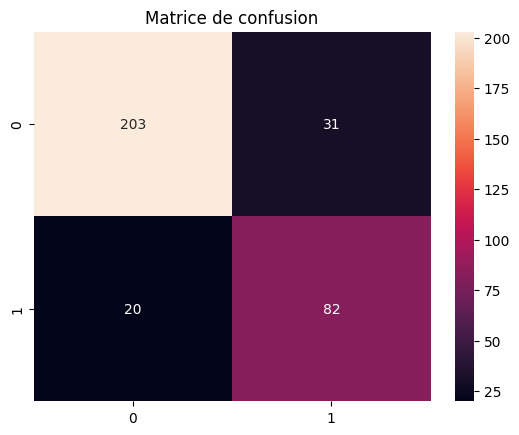

In [87]:
sns.heatmap(confusion_matrix(y_pred,y_test),fmt='.4g', annot=True).set_title('Matrice de confusion')

### `RandomForestClassifier`

In [30]:
def objective(trial):
    """Define the objective function"""

    params = {
    'n_estimators' : trial.suggest_int('n_estimators', 300, 500),
    'max_depth' : trial.suggest_int('max_depth', 5, 15),
    'min_samples_split' : trial.suggest_int('min_samples_split', 10, 30),
    'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"])
    }

    # Fit the model
    optuna_model = RandomForestClassifier(**params)
    optuna_model.fit(x_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(x_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred)
    return f1

In [52]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-01-30 22:21:39,905] A new study created in memory with name: no-name-da9767b4-4081-440a-9765-35e02fa4e302
[I 2023-01-30 22:21:44,470] Trial 0 finished with value: 0.6881720430107527 and parameters: {'n_estimators': 491, 'max_depth': 8, 'min_samples_split': 24, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6881720430107527.
[I 2023-01-30 22:21:48,215] Trial 1 finished with value: 0.7096774193548386 and parameters: {'n_estimators': 406, 'max_depth': 8, 'min_samples_split': 17, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7096774193548386.
[I 2023-01-30 22:21:52,874] Trial 2 finished with value: 0.7165775401069518 and parameters: {'n_estimators': 484, 'max_depth': 12, 'min_samples_split': 12, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7165775401069518.
[I 2023-01-30 22:21:57,195] Trial 3 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 477, 'max_depth': 13, 'min_samples_split': 25, 'criterion': 'gini'}. Best is trial 2 with va

### Save final model - `XGBClassifier`

In [ ]:
model_path = "../backup/models/xgb_model.pkl"
pickle.dump(xgb_clf, open(model_path, 'wb'))

In [88]:
xgb_clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.07750577429020981, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.003197155005876287, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.011202205787774437, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=459, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)